* Load model trained and saved in previous stage
* * Lora/QLORa model
  

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# !conda install -c conda-forge google-colab -y

# !pip install tensorflow  -U -q # ankh

# !pip install torch  -U -q # fair-esm # seqeval
# !pip3 install transformers peft accelerate datasets evaluate bitsandbytes -U -q # --user
# !pip install peft bitsandbytes -U

* Use the unirpot fasta file I downloaded and uploaded to my drive

`/content/drive/MyDrive/Research/biodata/proteins/Transmembrane_human_90.fasta`

* Download fasta from: `https://www.uniprot.org/uniref/?query=uniprot:(keyword%3A%22Transmembrane+%5BKW-0812%5D%22+AND+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22)+identity:0.9`

In [2]:
#### DATA_PATH = "/content/drive/MyDrive/Research/CIDR-Protein Anomalies project/protein_anomalies_data/swp_human_viri_all_embed_esm.parquet" ## ESM1B embedding (max len 1022)
# DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/hum_vir_swp-globalEmbed-train.csv.gz"## TRAIN
# DATA_PATH = "/content/drive/MyDrive/hum_vir_swp-globalEmbed-train.csv.gz"
# DATA_PATH = "/kaggle/input/humvir-proteins/hum_vir_swp-globalEmbed-train.csv/hum_vir_swp-globalEmbed-train.csv"
DATA_PATH = "hum_vir_swp-globalEmbed-train.csv.gz"

## TEST data:
# TEST_DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/hum_vir_swp-globalEmbed-test.csv.gz"## TRAIN
# TEST_DATA_PATH = "/content/drive/MyDrive/hum_vir_swp-globalEmbed-test.csv.gz"
# TEST_DATA_PATH = "/kaggle/input/humvir-proteins/hum_vir_swp-globalEmbed-test.csv/hum_vir_swp-globalEmbed-test.csv"
TEST_DATA_PATH = "hum_vir_swp-globalEmbed-test.csv.gz"

# ## metadata for all reviewed/swissprot human + virus proteins
# METADATA_PATH = "/content/drive/MyDrive/Research/CIDR-Protein Anomalies project/protein_anomalies_data/SWP_human_viruses_all.xlsx"

TARGET_COL = "virus" ## use for filtering data into 1 class

MAX_LEN = 1024#768#530 # exclude sequences longer than this. (Not merely truncate)

FAST_RUN = False#True
SAVE_MODEL = False#True

# MODEL_DRIVE_SAVE_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/trained_esm_lora_trainer_model"
MODEL_DRIVE_SAVE_PATH =  "./esm_lora_trainer_model_sml"
# MODEL_DRIVE_SAVE_PATH = "final"
# MODEL_DRIVE_SAVE_PATH = "/kaggle/input/humvir-proteins/qlora/qlora" # saved + reuploadedon kaggle

TRAIN_MODEL = False
LOAD_TRAINED =  True#False# True

In [3]:
import torch
import tensorflow
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
from sklearn.preprocessing  import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict
# from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
# from sklearn.ensemble import HistGradientBoostingClassifier
from tqdm.autonotebook import tqdm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score
from torch import nn
from transformers import TrainingArguments, Trainer, logging
from accelerate import Accelerator
from torch.utils.data.dataloader import DataLoader
## https://huggingface.co/docs/transformers/perf_train_gpu_one

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AdamWeightDecay
# from tensorflow.keras.optimizers import Adafactor, Adam # more memory effecient than adamWD
# import tensorflow
# from tensorflow.keras.metrics.AUC()
from transformers import AutoTokenizer, EsmForSequenceClassification, Trainer
from transformers import TFAutoModelForSequenceClassification ,TFEsmForSequenceClassification
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, BitsAndBytesConfig
from peft import AutoPeftModelForSequenceClassification, AutoPeftModel
from transformers import pipeline

## could use transformer pipeline for inference;
import datasets
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from peft import PeftModelForSequenceClassification, get_peft_config
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AdamWeightDecay
from tensorflow.keras.optimizers import Adafactor, Adam # more memory effecient than adamWD
import tensorflow
# from tensorflow.keras.metrics.AUC()
# from transformers import AutoTokenizer #DataCollatorForLanguageModeling,
## https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example
from transformers import AutoTokenizer, EsmForSequenceClassification, Trainer
from transformers import TFAutoModelForTokenClassification, TFAutoModelForSequenceClassification ,TFEsmForSequenceClassification

from peft import prepare_model_for_kbit_training, get_peft_model
from sklearn.metrics import precision_recall_fscore_support,accuracy_score,roc_auc_score
import evaluate

from datasets import load_metric
import torch._dynamo
torch._dynamo.config.suppress_errors = True
    
# pipe = pipeline("text-classification", model="facebook/wav2vec2-base-960h", device=0)

2024-03-09 23:40:10.191828: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 23:40:10.384036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 23:40:10.384065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 23:40:10.416397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 23:40:10.485916: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import wandb
wandb.init(mode="disabled")
# alt 
# wandb.init(project='qlora_humvir')# ; or args = TrainingArguments(report_to="none")

In [5]:
from accelerate import Accelerator
# # Use the accelerator
# ### try disabling? (with qlora)
# # accelerator = Accelerator()# trying this
# # שבבקךקרשאםר צשטנק בשודקד ןדדוקד?
accelerator = Accelerator(mixed_precision="fp16") #bf16") # fp16 # orig used

In [6]:
# model_checkpoint ="facebook/esm2_t6_8M_UR50D"
model_checkpoint =  "facebook/esm2_t12_35M_UR50D"
# model_checkpoint =  "facebook/esm2_t30_150M_UR50D"
# model_checkpoint =  "facebook/esm2_t33_650M_UR50D"

if FAST_RUN:
    # model_checkpoint ="facebook/esm2_t6_8M_UR50D"
  model_checkpoint =  "facebook/esm2_t12_35M_UR50D"


In [7]:
# df = pd.read_parquet(DATA_PATH) # numpy to pandas
df = pd.read_csv(DATA_PATH,usecols=["Sequence","virus","Length","Cluster name"])
df_test = pd.read_csv(TEST_DATA_PATH,usecols=["Sequence","virus","Length",	"Cluster name"])
 ## lengths of all the seqs

if FAST_RUN:
#   # df.loc[df["Length"]>100]
    df = df.sample(frac=0.12,random_state=4)
    df_test = df_test.sample(frac=0.35,random_state=4)
df

,Sequence,virus,Length,Cluster name
0,MADFLKGLPVYNKSNFSRFHADSVCKASNRRPSVYLPTREYPSEQI...,0,102,Cluster: DET1- and DDB1-associated protein 1
1,MPSTLQVLAKKVLALEHKENDHISREYYYHILKCCGLWWHEAPIIL...,1,362,Cluster: Protein MGF 360-19R
2,MASSAELDFNLQALLEQLSQDELSKFKSLIRTISLGKELQTVPQTE...,0,97,Cluster: Pyrin domain-containing protein 2
3,MAAWGKKHAGKDPVRDECEERNRFTETREEDVTDEHGEREPFAETD...,0,186,Cluster: Protein FAM9B
4,MASDSPARSLDEIDLSALRDPAGIFELVELVGNGTYGQVYKGRHVK...,0,1360,Cluster: TRAF2 and NCK-interacting protein kinase
...,...,...,...,...
20335,MDPDKQDALNSIENSIYRTAFKLQSVQTLCQLDLIDSSLIQQVLLR...,0,578,Cluster: Dystrotelin
20336,MLCPWRTANLGLLLILTIFLVAEAEGAAQPNNSLMLQTSKENHALA...,0,348,Cluster: Cell surface glycoprotein CD200 recep...
20337,MCLRFFSPVPGSTSSATNVTMVVSAGPWSSEKAEMNILEINEKLRP...,0,421,Cluster: Putative neuroblastoma breakpoint fam...
20338,MASHAGQQHAPAFGQAARASGPTDGRAASRPSHRQGASEARGDPEL...,1,376,Cluster: Thymidine kinase


In [8]:
ID2LABEL = {
    0: "Human",
    1: "Virus"
}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

In [9]:
# train_sequences = df["Sequence"].tolist()
# train_labels = df["virus"].tolist()
# train_groups = df["Cluster name"].tolist()

# train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.25, shuffle=True)#,stratify=labels)


In [10]:
##https://huggingface.co/docs/peft/main/en/developer_guides/quantization
## lotfQ config - for this, do not initialize as quantized!
# from peft import LoftQConfig, LoraConfig, get_peft_model
# loftq_config = LoftQConfig(loftq_bits=4)

## https://huggingface.co/blog/4bit-transformers-bitsandbytes
# compute_dtype = getattr(torch, "float16")
compute_dtype = getattr(torch, "bfloat16")

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True, # disable to train ok;
  # load_in_8bit=True, # alt
  bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
    # bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_has_fp16_weight =True,
    llm_int8_threshold = 5.1,
   bnb_4bit_compute_dtype=compute_dtype
    ,llm_int8_skip_modules=['classifier',"EsmClassificationHead"] # was enabled? 
)

model_max_len = min(1024,MAX_LEN) # 800

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,
                                          padding= True
#                                           padding= True# alt
                                          ,truncation=True,max_length=model_max_len)

num_labels = 2#max(train_labels + test_labels) + 1  # Add 1 since 0 can be a label
print("Num labels:", num_labels)

# ## https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb#scrollTo=fc164b49 # uses trainer
# ##

# # model = AutoModelForSequenceClassification. # orig
# # model = EsmForSequenceClassification.
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
#                                                            problem_type="single_label_classification", # was enabled
#                                                            # load_in_4bit=True, # disable to train ok
#                                                             quantization_config=nf4_config,
#                                                           #  load_in_8bit=True,  torch_dtype=torch.float32, # try this - new
#                                                            # device_map= "cuda:0",#"auto",
#                                                            device_map="auto",
#                                                           num_labels=len(ID2LABEL), id2label=ID2LABEL, label2id=LABEL2ID,
#                                                             # trust_remote_code=True
#                                                            # , from_tf=True,
#                                                            # force_download =True,
#                                                           )

# # last_layer_num = model.num_layers ## 33 for esm2_t33_650M_UR50D
# # print(last_layer_num )
# model.train()
# # model.print_trainable_parameters()

Num labels: 2


* `task_type= "SEQ_CLS"` - breaks - RuntimeError: only Tensors of floating point dtype can require gradients

In [11]:
## https://huggingface.co/blog/AmelieSchreiber/esmbind
# https://huggingface.co/docs/peft/task_guides/token-classification-lora
### target modules?? https://discuss.huggingface.co/t/esm-2-qlora-gradient-checkpointing-not-compatible/53505/2
## could also set to all linear? 

### https://huggingface.co/docs/peft/task_guides/semantic_segmentation_lora#wrap-the-base-model-as-a-peftmodel-for-lora-training
import bitsandbytes as bnb

peft_config = LoraConfig(base_model_name_or_path= MODEL_DRIVE_SAVE_PATH #model_checkpoint,
    ,task_type= TaskType.SEQ_CLS,#"SEQ_CLS",#, ## disabling helps?? (then get "ValueError: Attempting to unscale FP16 gradients.")
    inference_mode=False, r= 2 if FAST_RUN else 8, #16,
    lora_alpha=8,
    # lora_dropout=0.1,
    use_rslora = True,
    # bias= "none",#"lora_only",#"none",#"all",
    # bias="all", #"lora_only",
    bias="lora_only",
    target_modules=  "all-linear"
    # # ### https://www.kaggle.com/code/andregrbnr/protein-sequence-classification
     # ,modules_to_save= # "all-linear",
      # ,modules_to_save=  [ 'classifier.dense', 'classifier.out_proj'],
#                       # "classifier",
         # ,modules_to_save= ["EsmClassificationHead"]
      
# #          "pooler",
# # # #                      'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight'
                     # ]
    ## 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight'
    # ,modules_to_save=["classifier"]
                         # ,modules_to_save=[ 'classifier.dense', 'classifier.out_proj']
)

# get_peft_model(model, peft_config)

# model = get_peft_model(model, peft_config)
# model.print_trainable_parameters()

peft_config = LoraConfig(base_model_name_or_path=model_checkpoint, ## MODEL_DRIVE_SAVE_PATH
    task_type= TaskType.SEQ_CLS,lora_alpha=8,use_rslora = True, bias= "lora_only",#"all", #"lora_only",
           target_modules=  "all-linear" ## causes save score bug; but won't work without this
)

In [12]:
## Warning - longer than allowed length - 1024
def get_train_test_dataseqs(train_sequences,test_sequences,train_labels,test_labels):
    train_tokenized = tokenizer( train_sequences,  truncation=True,max_length=model_max_len,padding=True,)
    test_tokenized = tokenizer(test_sequences,  truncation=True,max_length=model_max_len,padding=True,)
    train_dataset = Dataset.from_dict(train_tokenized)
    test_dataset = Dataset.from_dict(test_tokenized)
    
    train_dataset = train_dataset.add_column("labels", train_labels)
    test_dataset = test_dataset.add_column("labels", test_labels)
    train_dataset

In [13]:
metric_acc = evaluate.load("accuracy")
metric = evaluate.load("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        # 'f1': f1,
        # 'precision': precision,
        # 'recall': recall,
        "roc_auc":roc_auc_score(labels,pred.predictions[:,1])
    }

In [14]:
# ### AttributeError: 'TFEsmForSequenceClassification' object has no attribute 'to'
model_name = model_checkpoint.split("/")[-1]
print(model_name)

training_args = TrainingArguments(
    f"{model_name}-finetuned-ft-humVir",
    # f"/content/drive/MyDrive/proteins/New Protein-Virus anom project/t{model_name}-finetuned-humVir",
    per_device_train_batch_size=32,
    # per_device_eval_batch_size=int(1.5*bch_size),
#     gradient_accumulation_steps= 2, #4,
    gradient_checkpointing=True,
    # fp16=True,
    bf16=True, # needs ampere, not supported ?
    tf32=True,
        # torch_compile = True,
    optim = "adamw_8bit", #"paged_adamw_8bit", # adamw_bnb_8bit
    # optim= "adamw_bnb_8bit", #"paged_adamw_8bit",
    label_names = ["labels"],
    learning_rate = 3e-4#2e-4 #5e-3,
    # lr_scheduler_type="cosine",
    ,max_grad_norm = 0.95,
    weight_decay=0.005,
    # eval_accumulation_steps = 2#8
    evaluation_strategy="epoch",
    save_strategy= "epoch",#"no",
    # output_dir=".",
     no_cuda=False,
     greater_is_better=True,
     # save_total_limit=1,
  remove_unused_columns=False,
    auto_find_batch_size = True, # new , reduces if oom
    # num_train_epochs=num_epochs,
    load_best_model_at_end=True,
    metric_for_best_model= "roc_auc",#"accuracy",
    group_by_length=True,
)

# trainer = Trainer(model=model, args=training_args,
#                   train_dataset=train_dataset,eval_dataset=test_dataset,tokenizer=tokenizer,
#                   compute_metrics=compute_metrics,)

esm2_t12_35M_UR50D


In [15]:
# if TRAIN_MODEL:
#     result = trainer.train()

### load model for **comparison**
* , untrained model ?
*  https://huggingface.co/blog/AmelieSchreiber/esmbind

In [16]:
model_checkpoint

'facebook/esm2_t12_35M_UR50D'

In [17]:
### https://huggingface.co/blog/AmelieSchreiber/esmbind
# # ESM2 base model
base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification")
base_model.eval()

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-0

In [18]:
# if FAST_RUN:
#   print("Untrained base model")
#   print(Trainer(model=base_model, args=training_args,
#                   train_dataset=train_dataset,eval_dataset=test_dataset,tokenizer=tokenizer,
#                   compute_metrics=compute_metrics,).evaluate()) # worse than trained model - OK!

In [19]:
MODEL_DRIVE_SAVE_PATH

'./esm_lora_trainer_model_sml'

In [20]:
# trained_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DRIVE_SAVE_PATH,
#                                                               num_labels=num_labels,problem_type="single_label_classification",
#                                                                   id2label=ID2LABEL, label2id=LABEL2ID,) #ORIG, worked

# # trained_model = PeftModel.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH) #ORIG, worked
# # alt":
# trained_model = PeftModelForSequenceClassification.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH,
#                                                                    config=peft_config) # alt

In [21]:
###
### it says it is not loading saved classifier weights?? but trainer pred gives ok results (better than with random model)? 
### load merge_unload model, not just poeft
if LOAD_TRAINED:
    """
    base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification")
    """
#   ### load pretrained, trained model?

    # trained_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=num_labels,problem_type="single_label_classification")
    # print("loading PEFT config")

    # trained_model = PeftModelForSequenceClassification.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH,
    #                                                                    config=peft_config) # alt
    
    trained_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DRIVE_SAVE_PATH,
                                                                  num_labels=num_labels,problem_type="single_label_classification",
                                                                      id2label=ID2LABEL, label2id=LABEL2ID,) #ORIG, worked
    merged_model = trained_model ## assumes loaded non peft model

    # # trained_model = PeftModel.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH) #ORIG, worked
    # # alt":
    # trained_model = PeftModelForSequenceClassification.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH,
    #                                                                    config=peft_config) # alt
    ## 
#     trained_model = prepare_model_for_kbit_training(trained_model, use_gradient_checkpointing=True)
    
else:
    trained_model = trainer.model
trained_model.eval()

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=640, out_features=640, bias=True)
              (key): Linear(in_features=640, out_features=640, bias=True)
              (value): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((640,), eps=1e-0

# res are same!

In [54]:
# merged_model = trained_model.merge_and_unload()
# merged_model

AttributeError: 'EsmForSequenceClassification' object has no attribute 'merge_and_unload'

In [23]:
## check if saved loaded ok?
if FAST_RUN:
  print(Trainer(model=trained_model, args=training_args,tokenizer=tokenizer,
                    train_dataset=train_dataset,eval_dataset=test_dataset,
                    compute_metrics=compute_metrics,).evaluate()) ## only ok if better than random init

In [24]:
if FAST_RUN:
  print(trainer.evaluate())

In [25]:
# if FAST_RUN:
#   print("merge and unload peft")
#   print(Trainer(model=merged_model, args=training_args,tokenizer=tokenizer,
#                     train_dataset=train_dataset,eval_dataset=test_dataset,
#                     compute_metrics=compute_metrics,).evaluate())

* Use HF pipeline
* Big bug with pipes - uses cpu? https://discuss.huggingface.co/t/text-classification-pipeline-very-slow-after-adding-padding-and-truncation-for-tokenizer/32173/3
* https://stackoverflow.com/questions/77249578/how-to-create-a-dataset-with-huggingface-from-a-list-of-strings-to-fine-tune-lla"

In [26]:
# https://huggingface.co/docs/transformers/en/main_classes/pipelines#pipeline-batching

# https://stackoverflow.com/questions/68197664/how-to-take-just-the-score-from-huggingface-pipeline-sentiment-analysis

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,
                                          # padding= False#True # orig
                                          padding= True ,truncation=True,max_length=model_max_len)

pipe = pipeline("text-classification",model=merged_model, tokenizer=tokenizer, truncation=True, top_k=1,device_map="auto") # top_k=None to get preds for each class
## return format is list of dicts, annoying to work with. for k=1 it's just the max class, annoying for a col per class proba score...

* Cao - maybe use only RBD domain ,  (+- mutation site?)


* Could get WT prediction, and get **delta** of mutant's predicted score vs wt - then examine that.



* https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example


* Eval related batch size stuff: https://discuss.huggingface.co/t/batch-size-for-trainer-predict/3374/2

In [27]:
# CAO_TEST_DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/cao_escaper_targets_max.csv"##
# CAO_TEST_DATA_PATH = "/kaggle/input/humvir-proteins/cao_escaper_targets_max.csv"
CAO_TEST_DATA_PATH = "cao_escaper_targets_max.csv"

### all data, more redundnat - same seq repeated, can join with our res to save time.
# CAO_full_TEST_DATA_PATH = "/kaggle/input/humvir-proteins/cao_escaper_targets_all.csv"
CAO_full_TEST_DATA_PATH = "cao_escaper_targets_all.csv.gz"

In [29]:
df_cao = pd.read_csv(CAO_TEST_DATA_PATH)
if FAST_RUN:
  df_cao = df_cao.head(200)

df_cao_full = pd.read_csv(CAO_full_TEST_DATA_PATH)
print(df_cao_full["seq"].nunique())
print(df_cao_full["seq"].str.len())
display(df_cao_full)

3820
0        1273
1        1273
2        1273
3        1273
4        1273
         ... 
34673    1273
34674    1273
34675    1273
34676    1273
34677    1273
Name: seq, Length: 34678, dtype: int64


,site,wildtype,mutation,mut_escape,seq,mut_escape_class
0,331,N,A,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
1,331,N,C,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
2,331,N,D,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
3,331,N,E,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
4,331,N,F,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
...,...,...,...,...,...,...
34673,489,Y,R,0.001041,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34674,489,Y,S,0.185581,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34675,489,Y,T,0.088192,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34676,489,Y,V,0.014363,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1


In [30]:
model_checkpoint

'facebook/esm2_t12_35M_UR50D'

In [32]:
from scipy.special import softmax
#OLD
def get_escaper_scores(df:pd.DataFrame,trained_model,base_model,seqColName="seq",truncate_cao=False,
                       binary_target_col = None):
  if truncate_cao:
  ## truncated version +-20:
    cao_sequences = df[seqColName].str[300:550].tolist() # ONLY RBD domain
    max_len = 550-300
  else:
    cao_sequences = df[seqColName].str[0:1024].tolist()
    max_len = df[seqColName].str.len().max()+2

  cao_test_seq = tokenizer(cao_sequences,  truncation=True
                          ,max_length= min(max_len,1024)#1024
                        #  max_length= 700 #600 #model_max_len,
                         ,padding=True#True,
                           # ,padding=True
                           ,return_tensors="pt")

  cao_test_seq = Dataset.from_dict(cao_test_seq)
  # cao_test_seq = accelerator.prepare(cao_test_seq)
    ## get naive models preds - WHY are they similar to trained models ???
  # """
  base_trainer = Trainer(base_model,tokenizer=tokenizer,args=training_args)
  raw_pred, _, _ = base_trainer.predict(cao_test_seq)
  # predictedLabelOnCompanyData = np.argmax(raw_pred, axis=1)
  # df["base_pred_vir"] = raw_pred[:,1]
  df["base_pred_vir"] = torch.nn.functional.softmax(torch.tensor(raw_pred), dim=1)[:,1]
  # """

  ## preds with proper model
  trainer = Trainer(model=trained_model,tokenizer=tokenizer,args=training_args) # added here...
    ### https://discuss.huggingface.co/t/transform-logits-to-probabilities-doesnt-work/14792
  logits, _, _ = trainer.predict(cao_test_seq)

  # print(softmax(logits[:,1]))
  # df["probabilities"] = softmax(logits[:,1]) #(preds_output[0], axis=1)#probabilities

  df["model_pred_vir"] =  torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,1]
  df["model_pred_hum"] =  torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,0]
  # df["sum"] = (df["model_pred_hum"]+df["model_pred_vir"]).round(2) # adds up to 1
  df["model_pred_hum_delta"] = df["model_pred_hum"].round(4)

  ## subtract WT pred score - to get deltas. WT is most common (as it reoccurs)
  mode_score = df["model_pred_hum"].round(4).mode()[0]
  df["model_pred_hum_delta"] = df["model_pred_hum_delta"] - mode_score
  print(df.describe().round(3))

  display(df.select_dtypes(["number","bool"]).corr().round(3))

  if binary_target_col is not None:
    print("humVir trained model - human pred delta - ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum_delta"]).round(4))
    print("humVir trained model ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum"]).round(4))
    print(classification_report(df[binary_target_col],np.argmax(logits, axis=-1)))
    print("Untrained vir model: ROCAUC",roc_auc_score(df[binary_target_col], df["base_pred_vir"]).round(4))

  return df


## newer, using pipeline (pretrained)
## https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#pipeline-batching
### pipeline approach here is MUCH slower! ? 
def pipe_get_escaper_scores(df:pd.DataFrame,trained_model,base_model,seqColName="seq",truncate_cao=False,
                       binary_target_col = None,model_checkpoint='facebook/esm2_t12_35M_UR50D'):
    """
    Much slower than old hacky approach of using a trainer ... 
    """
    if truncate_cao:
        ## truncated version +-20:
        cao_sequences = df[seqColName].str[300:550].tolist() # ONLY RBD domain
        max_len = 550-300
    else:
        cao_sequences = df[seqColName].str[0:1024].tolist()
        max_len = df[seqColName].str.len().max()+2
        
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,padding= True ,truncation=True,max_length=min(max_len,1024),is_split_into_words=False)

    def do_tokenization(example):
        """
        use like 
        dataset = dataset.map(do_tokenization, batched=True)
        """
        return tokenizer(example["text"])

    # cao_sequences = tokenizer(cao_sequences, truncation=True,max_length=model_max_len,is_split_into_words=False) ## ,return_tensors='pt'

    # cao_sequences = Dataset.from_dict(cao_sequences)
    # encoded_dataset = dataset.map(lambda examples: tokenizer(examples['sentence1']),
    #                           batched=True)
    # 
    # cao_sequences = Dataset.from_list(tokenizer(cao_sequences,  truncation=True,max_length=model_max_len,padding=False))#.map(tokenizer, batched=True)
    # cao_sequences = Dataset.from_pandas(pd.DataFrame(cao_sequences)).map(tokenizer, batched=True)
    # cao_sequences = Dataset.from_pandas(df[seqColName])
    
    # cao_test_seq = tokenizer(cao_sequences,  truncation=True
    #                       ,max_length= min(max_len,1024)#1024
    #                     #  max_length= 700 #600 #model_max_len,
    #                      ,padding=False#True,
    #                        # ,padding=True
    #                        ,return_tensors="pt")
    
    # cao_test_seq = Dataset.from_dict(cao_test_seq)
    # # cao_test_seq = accelerator.prepare(cao_test_seq)
    # ## get naive models preds - WHY are they similar to trained models ???
    
    def set_vir_label_scores(row):
        """
        Get the virus score per row, (and we can externally set human score from that).
        Assumes model_score col is the k=1 / top score
        """
        if row.model_label.lower() == "virus":
            return row.model_score
        else:
            return 1-row.model_score
            

    ### naive model - should be random res
    naive_classifier_pipe = pipeline("text-classification",model=base_model, tokenizer=tokenizer,device=0, top_k=1,batch_size=16) # ,device_map="auto" 
    # naive_classifier_pipe = pipeline("text-classification",model=base_model, tokenizer=tokenizer, top_k=1,device=0) 
    naive_preds = naive_classifier_pipe(cao_sequences)
    naive_preds_labels = [i[0]["label"] for i in naive_preds]
    naive_preds_top_score = [i[0]["score"] for i in naive_preds]
    df["model_label"] = naive_preds_labels
    df["model_label"] = df["model_label"].str.lower()
    df["model_score"] = naive_preds_top_score
    
    df["base_pred_vir"] = df.apply(set_vir_label_scores, axis=1)
    df.drop(columns=["model_label","model_score"],inplace=True,errors="ignore")
    
    ## get proepr trained models predictions
    pipe = pipeline("text-classification",model=trained_model, tokenizer=tokenizer, top_k=1,batch_size=16,device=0)  # ,truncation=True
    # pipe = pipeline("text-classification",model=trained_model, tokenizer=tokenizer, top_k=1,device=0) 
    ## pipeline (with k=1) returns label, score for top label, need to get per lavbel
    preds = pipe(cao_sequences)
    preds_labels = [i[0]["label"] for i in preds]
    preds_top_score = [i[0]["score"] for i in preds]

    df["model_label"] = preds_labels
    df["model_label"] = df["model_label"].str.lower()
    df["model_score"] = preds_top_score
    
    df["model_pred_vir"] = df.apply(set_vir_label_scores, axis=1)
    df["model_pred_hum"] = 1-df["model_pred_vir"]
    df["model_pred_hum_delta"] = df["model_pred_hum"].round(4)
    
    ## subtract WT pred score - to get deltas. WT is most common (as it reoccurs)
    mode_score = df["model_pred_hum"].round(4).mode()[0]
    df["model_pred_hum_delta"] = df["model_pred_hum_delta"] - mode_score
    print(df.describe().round(3))
    
    display(df.select_dtypes(["number","bool"]).corr().round(3))
    
    if binary_target_col is not None:
        print("humVir trained model - human pred delta - ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum_delta"]).round(4))
        print("humVir trained model ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum"]).round(4))
        # print(classification_report(df[binary_target_col],np.argmax(logits, axis=-1)))
        print(classification_report(df[binary_target_col],df["model_label"]==1))
        print("Untrained vir model: ROCAUC",roc_auc_score(df[binary_target_col], df["base_pred_vir"]).round(4))
        
    return df
    
# get_escaper_scores(df_iedb_vir.sample(16).copy(),trained_model=model,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)

# pipe_get_escaper_scores(df_cao.head(120).copy(),trained_model= merged_model#trainer.model,
#                    ,base_model=base_model,seqColName="seq",truncate_cao=True,
#                        binary_target_col = "mut_escape_class")

In [32]:
df_cao

,site,wildtype,mutation,mut_escape,mut_escape_class,seq
0,331,N,A,0.009428,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
1,331,N,C,0.000000,0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
2,331,N,D,0.026596,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,331,N,E,0.112258,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4,331,N,F,0.012256,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
...,...,...,...,...,...,...
4015,531,T,S,0.010178,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4016,531,T,T,0.000000,0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4017,531,T,V,0.009521,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4018,531,T,W,0.008336,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...


In [33]:
%%time
### 12 sec
df_cao_preds = get_escaper_scores(df_cao.copy(),trained_model= merged_model#model, #trainer,
                   ,base_model=base_model,seqColName="seq",truncate_cao=True,
                       binary_target_col = "mut_escape_class")

## fast run. NOTE! trained model res are different than when using pipe!... !
# humVir trained model - human pred delta - ROCAUC: 0.4858
# humVir trained model ROCAUC: 0.4858
# Untrained vir model: ROCAUC 0.4922

          site  mut_escape  mut_escape_class  base_pred_vir  model_pred_vir  \
count  4020.00    4020.000          4020.000       4020.000          4020.0   
mean    431.00       0.197             0.528          0.478             1.0   
std      58.03       0.335             0.499          0.000             0.0   
min     331.00       0.000             0.000          0.476             1.0   
25%     381.00       0.000             0.000          0.478             1.0   
50%     431.00       0.007             1.000          0.478             1.0   
75%     481.00       0.305             1.000          0.478             1.0   
max     531.00       3.602             1.000          0.481             1.0   

       model_pred_hum  model_pred_hum_delta  
count          4020.0                4020.0  
mean              0.0                  -0.0  
std               0.0                   0.0  
min               0.0                  -0.0  
25%               0.0                  -0.0  
50%         

,site,mut_escape,mut_escape_class,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
site,1.000,0.073,0.093,0.145,0.192,-0.192,-0.151
mut_escape,0.073,1.000,0.555,0.060,0.060,-0.060,-0.056
mut_escape_class,0.093,0.555,1.000,-0.057,0.094,-0.094,-0.105
base_pred_vir,0.145,0.060,-0.057,1.000,0.038,-0.038,-0.027
model_pred_vir,0.192,0.060,0.094,0.038,1.000,-1.000,-0.787
model_pred_hum,-0.192,-0.060,-0.094,-0.038,-1.000,1.000,0.787
model_pred_hum_delta,-0.151,-0.056,-0.105,-0.027,-0.787,0.787,1.000


humVir trained model - human pred delta - ROCAUC: 0.4486
humVir trained model ROCAUC: 0.4528
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1897
           1       0.53      1.00      0.69      2123

    accuracy                           0.53      4020
   macro avg       0.26      0.50      0.35      4020
weighted avg       0.28      0.53      0.37      4020

Untrained vir model: ROCAUC 0.4666
CPU times: user 18.8 s, sys: 2.14 s, total: 21 s
Wall time: 21.1 s


/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [34]:
%%time
###  slower
df_cao_preds = pipe_get_escaper_scores(df_cao.copy(),trained_model= merged_model#trainer.model,
                   ,base_model=base_model,seqColName="seq",truncate_cao=True,
                       binary_target_col = "mut_escape_class")

### 1 min for all 
## fast run. NOTE! trained model res are different than when not using pipe!... !
# humVir trained model - human pred delta - ROCAUC: 0.4798
# humVir trained model ROCAUC: 0.4798
# Untrained vir model: ROCAUC 0.4922

          site  mut_escape  mut_escape_class  base_pred_vir  model_score  \
count  4020.00    4020.000          4020.000       4020.000       4020.0   
mean    431.00       0.197             0.528          0.478          1.0   
std      58.03       0.335             0.499          0.000          0.0   
min     331.00       0.000             0.000          0.476          1.0   
25%     381.00       0.000             0.000          0.478          1.0   
50%     431.00       0.007             1.000          0.478          1.0   
75%     481.00       0.305             1.000          0.478          1.0   
max     531.00       3.602             1.000          0.481          1.0   

       model_pred_vir  model_pred_hum  model_pred_hum_delta  
count          4020.0          4020.0                4020.0  
mean              1.0             0.0                  -0.0  
std               0.0             0.0                   0.0  
min               1.0             0.0                  -0.0  
25%  

,site,mut_escape,mut_escape_class,base_pred_vir,model_score,model_pred_vir,model_pred_hum,model_pred_hum_delta
site,1.000,0.073,0.093,0.167,0.203,0.203,-0.203,-0.159
mut_escape,0.073,1.000,0.555,0.068,0.055,0.055,-0.055,-0.046
mut_escape_class,0.093,0.555,1.000,-0.032,0.077,0.077,-0.077,-0.059
base_pred_vir,0.167,0.068,-0.032,1.000,0.036,0.036,-0.036,0.011
model_score,0.203,0.055,0.077,0.036,1.000,1.000,-1.000,-0.752
model_pred_vir,0.203,0.055,0.077,0.036,1.000,1.000,-1.000,-0.752
model_pred_hum,-0.203,-0.055,-0.077,-0.036,-1.000,-1.000,1.000,0.752
model_pred_hum_delta,-0.159,-0.046,-0.059,0.011,-0.752,-0.752,0.752,1.000


humVir trained model - human pred delta - ROCAUC: 0.4776
humVir trained model ROCAUC: 0.4698
              precision    recall  f1-score   support

           0       0.47      1.00      0.64      1897
           1       0.00      0.00      0.00      2123

    accuracy                           0.47      4020
   macro avg       0.24      0.50      0.32      4020
weighted avg       0.22      0.47      0.30      4020

Untrained vir model: ROCAUC 0.491
CPU times: user 20.2 s, sys: 1.55 s, total: 21.8 s
Wall time: 22 s


/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [35]:
# %%time 
### works but very slow 
# # model_saved(**inputs)
# samples = df_cao.head(70)["seq"].to_list()
# merged_model(**tokenizer(samples,truncation=True,return_tensors='pt'))

In [36]:
# df_cao["model_pred_vir"].describe().round(4)
# df_cao["model_pred_hum"].value_counts() ## most common (271) value - unmutated score/WT

In [37]:
df_cao.select_dtypes(["number","bool"]).corr().round(3)

,site,mut_escape,mut_escape_class
site,1.000,0.073,0.093
mut_escape,0.073,1.000,0.555
mut_escape_class,0.093,0.555,1.000


In [38]:
## merge preds and plot vs escaper score (across many conditions. partially dedupped by cond + identicals)
df_cao_full["seq"].nunique()

3820

In [39]:
print(df_cao_full.shape[0])
df_cao_full = df_cao_full[['mut_escape', 'seq', 'mut_escape_class']].drop_duplicates()
print(df_cao_full.shape[0])

34678
34478


In [40]:
df_cao_preds["seq"].nunique()

3820

In [41]:
df_cao_preds.shape[0]
## there are multiple preds of different outputs values for the same identical mutation sequence. ? 
## we'll take the max ? or plot all? 
# df_cao_preds.groupby('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']].max()

4020

In [42]:
## more rows made? 
# df_cao_full.merge(df_cao_preds.set_index('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']],on='seq')

# df_cao_full_merged = df_cao_full.merge(df_cao_preds.groupby('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']].max(),on='seq')
# alt:
df_cao_full_merged = df_cao_full.merge(df_cao_preds.set_index('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']],on='seq')
df_cao_full_merged

,mut_escape,seq,mut_escape_class,base_pred_vir,model_pred_hum,model_pred_hum_delta
0,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.477455,0.000325,0.0000
1,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.476597,0.000296,0.0000
2,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.477615,0.000305,0.0000
3,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.477615,0.000368,0.0001
4,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.476964,0.000287,0.0000
...,...,...,...,...,...,...
34673,0.001041,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.478239,0.000282,0.0000
34674,0.185581,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.478133,0.000310,0.0000
34675,0.088192,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.478011,0.000287,0.0000
34676,0.014363,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.478102,0.000269,0.0000


In [43]:
df_cao_full_merged.corr(numeric_only=True).round(3)

,mut_escape,mut_escape_class,base_pred_vir,model_pred_hum,model_pred_hum_delta
mut_escape,1.000,0.210,0.052,-0.005,-0.032
mut_escape_class,0.210,1.000,0.033,-0.040,-0.024
base_pred_vir,0.052,0.033,1.000,-0.052,0.052
model_pred_hum,-0.005,-0.040,-0.052,1.000,0.718
model_pred_hum_delta,-0.032,-0.024,0.052,0.718,1.000


In [44]:
df_cao_full_merged.columns

Index(['mut_escape', 'seq', 'mut_escape_class', 'base_pred_vir',
       'model_pred_hum', 'model_pred_hum_delta'],
      dtype='object')

In [45]:
df_cao_full_merged[["base_pred_vir","model_pred_hum","model_pred_hum_delta"]].corrwith(df_cao_full_merged,numeric_only=True)

base_pred_vir           1.0
model_pred_hum          1.0
model_pred_hum_delta    1.0
mut_escape              NaN
mut_escape_class        NaN
dtype: float64

In [46]:
# print(classification_report(df_cao["mut_escape_class"],np.argmax(logits, axis=-1)))

Viral escape data:

```
!wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
!tar xvf data.tar.gz
```
* https://github.com/brianhie/viral-mutation/tree/master/results
* wget from : https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/sequences-key.ipynb#scrollTo=VN607f41e_qp
  * relatively large - 3GB zipped!


Example output from them (maybe cov2 seq), with escaper results value:
https://github.com/brianhie/viral-mutation/blob/master/examples/example_results.txt

* another for flu (1, h3)... https://github.com/brianhie/viral-mutation/blob/master/results/flu/semantics/analyze_semantics_flu_h1_bilstm_512.txt

In [28]:
# !wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
# !tar xvf data.tar.gz
### https://github.com/brianhie/viral-mutation/blob/81c80d41671670eb58cc46e957a1b0c4bf14856a/bin/escape.py#L5
# # pd.read_csv('data/influenza/escape_doud2018/pos_map.csv')

In [29]:
df_ex = pd.read_csv("https://raw.githubusercontent.com/brianhie/viral-mutation/master/examples/example_results.txt",sep="\t",header=0)
df_ex

,Mutations,Semantic change,Grammaticality,ID,Sequence
0,"H69del,V70del,Y144del,N501Y,A570D,P681H,T716I,...",2.0900,-4.426438,B.1.1.7,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
1,"D80A,D215G,K417N,E484K,N501Y,A701V",2.3320,-3.571184,V501.V2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
2,"F140del,Y248del,249insK,249insT,249insR,249ins...",2.5590,-5.231962,PT188-EM,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,"V3I,D614G",0.7217,-1.438198,null0,MFIFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4,"L5F,T22I",1.0260,-2.518009,null1,MFVFFVLLPLVSSQCVNLTTRIQLPPAYTNSFTRGVYYPDKVFRSS...
...,...,...,...,...,...
909,L8V,0.4204,-2.274710,null906,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
910,"L8V,D138Y",0.9610,-3.060831,null907,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
911,"L8W,D614G",0.9240,-2.423046,null908,MFVFLVLWPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
912,F2L,0.5740,-2.516092,null909,MLVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...


In [30]:
df_ex = get_escaper_scores(df_ex,trained_model=merged_model,base_model=base_model,seqColName="Sequence",truncate_cao=False)

NameError: name 'get_escaper_scores' is not defined

In [ ]:
df_ex

#### DeepImmuno train data
* https://github.com/frankligy/DeepImmuno/blob/main/reproduce/data/remove0123_sample100.csv
*  this is the train set from there
*  * Deep-learning empowered prediction and generation of immunogenic epitopes for T cell immunity

In [33]:
df_immuno_train = pd.read_csv("DeepImmuno_train_remove0123_sample100.csv")
df_immuno_train

,peptide,HLA,immunogenicity,test,respond,potential
0,KEHVFFSEY,HLA-B*4402,Negative,4,0,0.347444
1,DEGATLYRF,HLA-B*4402,Negative,4,0,0.346545
2,TLAARIKFL,HLA-A*0201,Negative,4,0,0.346239
3,KETLNEYKQL,HLA-B*4402,Negative,4,0,0.345162
4,STTDAEACY,HLA-A*0101,Negative,4,0,0.343674
...,...,...,...,...,...,...
8966,YYMATLKNV,HLA-A*2402,Positive,50,1,0.370625
8967,ILMNDQEVGV,HLA-A*0201,Positive,89,13,0.356673
8968,ALYEKKLAL,HLA-A*0201,Positive,80,3,0.300920
8969,GIIYIIYKL,HLA-A*0201,Positive,89,4,0.280177


In [34]:
df_immuno_train.nunique()

peptide           8383
HLA                104
immunogenicity       5
test                64
respond             44
potential         8970
dtype: int64

In [35]:
df_immuno_train.immunogenicity.value_counts()

immunogenicity
Negative                 4912
Positive                 3747
Positive-Low              187
Positive-High              87
Positive-Intermediate      38
Name: count, dtype: int64

In [36]:
df_immuno_train["pos_immunogen"] = df_immuno_train["immunogenicity"].str.contains("Positive",case=False,na=False).astype(int)

In [37]:
df_immuno_train_res = get_escaper_scores(df_immuno_train,trained_model=merged_model,base_model=base_model,seqColName="peptide",truncate_cao=False,binary_target_col="pos_immunogen")

           test   respond  potential  pos_immunogen  base_pred_vir  \
count  8971.000  8971.000   8971.000       8971.000       8971.000   
mean      6.706     0.891      0.543          0.452          0.469   
std       8.578     3.351      0.341          0.498          0.003   
min       0.000     0.000      0.031          0.000          0.458   
25%       2.000     0.000      0.265          0.000          0.467   
50%       5.000     0.000      0.310          0.000          0.469   
75%       9.000     0.000      0.964          1.000          0.471   
max      91.000    79.000      0.985          1.000          0.485   

       model_pred_vir  model_pred_hum  model_pred_hum_delta  
count        8971.000        8971.000              8971.000  
mean            0.283           0.717                -0.187  
std             0.303           0.303                 0.303  
min             0.000           0.000                -0.905  
25%             0.039           0.537                -0.368

,test,respond,potential,pos_immunogen,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
test,1.000,0.481,-0.345,-0.121,0.001,-0.018,0.018,0.018
respond,0.481,1.000,0.237,0.292,-0.023,-0.053,0.053,0.053
potential,-0.345,0.237,1.000,0.962,-0.089,-0.139,0.139,0.139
pos_immunogen,-0.121,0.292,0.962,1.000,-0.102,-0.148,0.148,0.148
base_pred_vir,0.001,-0.023,-0.089,-0.102,1.000,-0.079,0.079,0.079
model_pred_vir,-0.018,-0.053,-0.139,-0.148,-0.079,1.000,-1.000,-1.000
model_pred_hum,0.018,0.053,0.139,0.148,0.079,-1.000,1.000,1.000
model_pred_hum_delta,0.018,0.053,0.139,0.148,0.079,-1.000,1.000,1.000


humVir trained model - human pred delta - ROCAUC: 0.5788
humVir trained model ROCAUC: 0.5788
              precision    recall  f1-score   support

           0       0.51      0.72      0.60      4912
           1       0.34      0.17      0.23      4059

    accuracy                           0.47      8971
   macro avg       0.42      0.45      0.41      8971
weighted avg       0.43      0.47      0.43      8971

Untrained vir model: ROCAUC 0.4435


In [38]:
df_immuno_train_res[['potential',
       'pos_immunogen', 'base_pred_vir', 'model_pred_vir', 'model_pred_hum',
       'model_pred_hum_delta']].corr().round(3)#.columns

,potential,pos_immunogen,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
potential,1.000,0.962,-0.089,-0.139,0.139,0.139
pos_immunogen,0.962,1.000,-0.102,-0.148,0.148,0.148
base_pred_vir,-0.089,-0.102,1.000,-0.079,0.079,0.079
model_pred_vir,-0.139,-0.148,-0.079,1.000,-1.000,-1.000
model_pred_hum,0.139,0.148,0.079,-1.000,1.000,1.000
model_pred_hum_delta,0.139,0.148,0.079,-1.000,1.000,1.000


### IEDB epitopes
*lots of (short) linear epitopes
* humans, viruses

In [39]:
df_iedb_human = pd.read_csv("iedb_human_epitopes.csv",compression="zip").drop_duplicates(subset=["Epitopes - Epitope"])
## raw - 1.1M seqs
print(df_iedb_human.nunique())
df_iedb_human

Epitopes - IEDB ID         1105596
Epitopes - Epitope         1105596
Epitopes - Antigen           27807
Epitopes - Organism              1
Epitopes - # References         75
Epitopes - # Assays            264
dtype: int64


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays
0,2,AAAAAAAAAAAAA,Solute carrier family 12 member 2,Homo sapiens (human),3,3
1,10,AAAAAIFVI,MHC class I polypeptide-related sequence A (Un...,Homo sapiens (human),2,4
2,11,AAAAALDKKQRNFDKILA,Myosin-7,Homo sapiens (human),1,1
3,129,AAEYWNSQKEVLER,HLA-DQB1*03:02 chain,NaN,2,2
4,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),42,121
...,...,...,...,...,...,...
1105591,2253039,LTVDKSRWQQGNVFSC,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,13
1105592,2253042,"LYSKLTVDKSRWQQGNVFS + SCM(K4, K9)",Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,2
1105593,2253050,NGSGSGKWEGGPSK,Potassium voltage-gated channel subfamily H me...,Homo sapiens (human),1,3
1105594,2253058,PPMMYPHPAYP,Galectin-9,Homo sapiens (human),1,12


In [40]:
df_iedb_human[['Epitopes - # References','Epitopes - # Assays']].max(axis=1).describe().round(1)

count    1105596.0
mean           3.3
std            8.0
min            1.0
25%            1.0
50%            1.0
75%            3.0
max          565.0
dtype: float64

### filter for higher confidence cases

In [41]:
df_iedb_human = df_iedb_human.loc[df_iedb_human[['Epitopes - # References','Epitopes - # Assays']].max(axis=1)>1]
print(df_iedb_human.shape[0])
df_iedb_human = df_iedb_human.loc[~df_iedb_human["Epitopes - Epitope"].str.contains("[\+ ]")]
print(df_iedb_human.shape[0])

df_iedb_human = df_iedb_human.loc[df_iedb_human["Epitopes - Epitope"].str.len()>4]
print(df_iedb_human.shape[0])

281062
266567
266526


In [42]:
df_iedb_human

,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays
0,2,AAAAAAAAAAAAA,Solute carrier family 12 member 2,Homo sapiens (human),3,3
1,10,AAAAAIFVI,MHC class I polypeptide-related sequence A (Un...,Homo sapiens (human),2,4
4,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),42,121
10,368,AAPPVAPA,Cellular tumor antigen p53 (UniProt:A0A0U1RQC9),Homo sapiens (human),1,5
11,375,AAPSVFIFPPSDEQLK,Other Homo sapiens (human) protein,Homo sapiens (human),2,3
...,...,...,...,...,...,...
1105590,2253021,KDTLMISRTPEVTCVV,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,18
1105591,2253039,LTVDKSRWQQGNVFSC,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,13
1105593,2253050,NGSGSGKWEGGPSK,Potassium voltage-gated channel subfamily H me...,Homo sapiens (human),1,3
1105594,2253058,PPMMYPHPAYP,Galectin-9,Homo sapiens (human),1,12


In [43]:
df_iedb_human["Epitopes - Epitope"].str.len().describe().round(0)

count    266526.0
mean         12.0
std           4.0
min           5.0
25%           9.0
50%          10.0
75%          14.0
max          53.0
Name: Epitopes - Epitope, dtype: float64

In [44]:
df_iedb_human_preds = get_escaper_scores(df_iedb_human.sample(50_123,).copy(),trained_model=merged_model # model,
                                         ,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)
df_iedb_human_preds

       Epitopes - IEDB ID  Epitopes - # References  Epitopes - # Assays  \
count           30123.000                30123.000            30123.000   
mean           798868.972                    5.356                9.692   
std            367631.753                    5.566               13.901   
min               434.000                    1.000                3.000   
25%            513602.500                    2.000                3.000   
50%            714093.000                    4.000                5.000   
75%           1113913.500                    6.000               10.000   
max           2253065.000                   81.000              377.000   

       base_pred_vir  model_pred_vir  model_pred_hum  model_pred_hum_delta  
count      30123.000       30123.000       30123.000             30123.000  
mean           0.471           0.190           0.810                -0.185  
std            0.003           0.256           0.256                 0.256  
min            0

,Epitopes - IEDB ID,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
Epitopes - IEDB ID,1.000,-0.476,-0.279,0.047,0.050,-0.050,-0.050
Epitopes - # References,-0.476,1.000,0.736,-0.044,-0.021,0.021,0.021
Epitopes - # Assays,-0.279,0.736,1.000,-0.019,0.004,-0.004,-0.004
base_pred_vir,0.047,-0.044,-0.019,1.000,-0.081,0.081,0.081
model_pred_vir,0.050,-0.021,0.004,-0.081,1.000,-1.000,-1.000
model_pred_hum,-0.050,0.021,-0.004,0.081,-1.000,1.000,1.000
model_pred_hum_delta,-0.050,0.021,-0.004,0.081,-1.000,1.000,1.000


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
864969,1815067,REEIVRYLRSVQLPDGG,Lanosterol synthase (Fragment) (UniProt:A0A0G2...,Homo sapiens (human),3,3,0.472014,0.354433,0.645567,-0.3488
142186,572087,EEVSPQLFTF,Kinesin-like protein KIF2A,Homo sapiens (human),7,8,0.475727,0.015664,0.984336,-0.0101
531428,1140348,FAQKVVPDPNVIK,ATP-dependent RNA helicase DDX19A,Homo sapiens (human),1,3,0.471527,0.017577,0.982423,-0.0120
195147,636596,RYFKGYFL,Glycerophosphocholine phosphodiesterase GPCPD1,Homo sapiens (human),4,4,0.469520,0.247987,0.752013,-0.2424
129410,550552,DDTQFVRFDSDATSPR,HLA class I antigen,Homo sapiens (human),3,3,0.475362,0.992539,0.007461,-0.9869
...,...,...,...,...,...,...,...,...,...,...
52384,444718,HHDFHHMNF,Methylsterol monooxygenase 1 (Fragment),Homo sapiens (human),7,10,0.468608,0.129403,0.870597,-0.1238
486619,1095136,ELNGAYKAIPVAQDLNAPS,Osteopontin,Homo sapiens (human),3,19,0.470128,0.041462,0.958538,-0.0359
79771,475055,AEINDLENL,Dual specificity mitogen-activated protein kin...,Homo sapiens (human),7,8,0.472927,0.201185,0.798815,-0.1956
312418,865382,SMANAGPNTNGSQF,Peptidyl-prolyl cis-trans isomerase A,Homo sapiens (human),2,11,0.472866,0.009268,0.990732,-0.0037


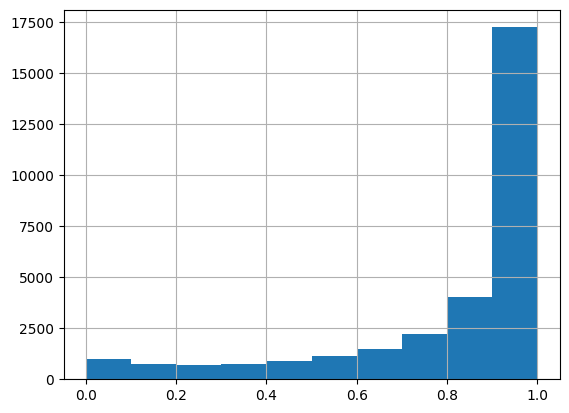

In [46]:
df_iedb_human_preds["model_pred_hum"].hist();

In [50]:
# "E:\Stuff\Research\datasets\New Protein-Virus anom project\iedb_vir_epitopes.csv.zip.csv"
df_iedb_vir = pd.read_csv("iedb_vir_epitopes.csv",compression="zip").drop_duplicates(subset=["Epitopes - Epitope"])
## raw - 138K seqs
print(df_iedb_vir.nunique())
# df_iedb_vir

df_iedb_vir = df_iedb_vir.loc[df_iedb_vir[['Epitopes - # References','Epitopes - # Assays']].max(axis=1)>1]
print(df_iedb_vir.shape[0])
df_iedb_vir = df_iedb_vir.loc[~df_iedb_vir["Epitopes - Epitope"].str.contains("[\+ ]")]
print(df_iedb_vir.shape[0])

df_iedb_vir = df_iedb_vir.loc[df_iedb_vir["Epitopes - Epitope"].str.len()>4]
print(df_iedb_vir.shape[0])

Epitopes - IEDB ID         138074
Epitopes - Epitope         138074
Epitopes - Antigen            844
Epitopes - Organism           182
Epitopes - # References        59
Epitopes - # Assays           103
dtype: int64
58544
58360
58352


In [58]:
df_iedb_vir_preds = get_escaper_scores(df_iedb_vir.sample(30_183).copy(),trained_model=merged_model,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)
df_iedb_vir_preds

       Epitopes - IEDB ID  Epitopes - # References  Epitopes - # Assays  \
count           30183.000                30183.000            30183.000   
mean          1018562.781                    1.733                3.777   
std            735418.209                    3.153                6.996   
min                24.000                    1.000                2.000   
25%            127003.000                    1.000                2.000   
50%           1421637.000                    1.000                2.000   
75%           1638950.500                    2.000                4.000   
max           2253121.000                  252.000              602.000   

       base_pred_vir  model_pred_vir  model_pred_hum  model_pred_hum_delta  
count      30183.000       30183.000       30183.000             30183.000  
mean           0.470           0.280           0.720                -0.275  
std            0.003           0.310           0.310                 0.310  
min            0

,Epitopes - IEDB ID,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
Epitopes - IEDB ID,1.000,-0.205,-0.192,0.137,0.054,-0.054,-0.054
Epitopes - # References,-0.205,1.000,0.819,-0.043,-0.012,0.012,0.012
Epitopes - # Assays,-0.192,0.819,1.000,-0.062,0.010,-0.010,-0.010
base_pred_vir,0.137,-0.043,-0.062,1.000,-0.032,0.032,0.032
model_pred_vir,0.054,-0.012,0.010,-0.032,1.000,-1.000,-1.000
model_pred_hum,-0.054,0.012,-0.010,0.032,-1.000,1.000,1.000
model_pred_hum_delta,-0.054,0.012,-0.010,0.032,-1.000,1.000,1.000


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
15851,71400,VTLFYCDER,Putative nuclease G5,Vaccinia virus (vaccinia virus VV),1,4,0.470980,0.756358,0.243642,-0.7513
97140,1541047,KLGSLVVRCSFYEDF,ORF8 protein,SARS-CoV2,2,3,0.467271,0.188922,0.811078,-0.1838
117758,1680225,MQGAVDINKLCEEMLD,Replicase polyprotein 1ab,SARS-CoV2,1,2,0.472623,0.193757,0.806243,-0.1887
64388,1425220,DVQFEQLDNKLP,Spike glycoprotein,Middle East respiratory syndrome-related coron...,1,3,0.471527,0.212722,0.787278,-0.2076
21586,88416,SDANTEYERLLSMLN,RNA-directed RNA polymerase L,Mammarenavirus choriomeningitidis (Lymphocytic...,1,13,0.472744,0.957912,0.042088,-0.9528
...,...,...,...,...,...,...,...,...,...,...
60185,1412470,ASCFFTCNSNAN,Spike glycoprotein,Human coronavirus NL63 (Coronavirus NL63),1,2,0.468487,0.069038,0.930962,-0.0639
133126,2152581,ELVLEVVFGGHWGVV,Genome polyprotein,Hepatitis C virus,1,2,0.470737,0.520070,0.479930,-0.5150
65335,1428224,EKSFQLDTAPKT,Spike glycoprotein,SARS-CoV1,1,2,0.475179,0.022803,0.977197,-0.0177
120344,1688389,QLSSYSLFDMSKFPLK,Replicase polyprotein 1ab,SARS-CoV2,1,2,0.467453,0.324235,0.675765,-0.3191


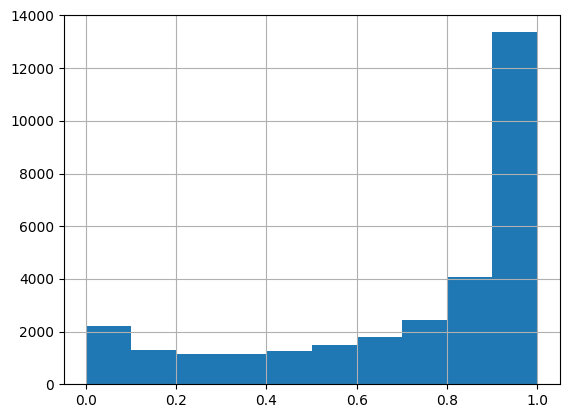

In [59]:
df_iedb_vir_preds["model_pred_hum"].hist();

In [60]:
df_iedb_vir_preds["label"]="vir"
df_iedb_human_preds["label"]="hum"

In [61]:
df_iedbs = pd.concat([df_iedb_vir_preds[["label","model_pred_hum"]],df_iedb_human_preds[["label","model_pred_hum"]]])
df_iedbs

,label,model_pred_hum
15851,vir,0.243642
97140,vir,0.811078
117758,vir,0.806243
64388,vir,0.787278
21586,vir,0.042088
...,...,...
52384,hum,0.870597
486619,hum,0.958538
79771,hum,0.798815
312418,hum,0.990732


In [ ]:
### FIG 3 

<Axes: xlabel='Predicted Humanness score', ylabel='Density'>

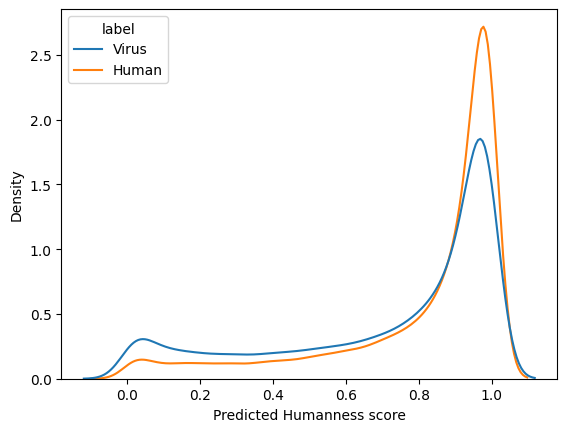

In [64]:
import seaborn as sns
# https://stackoverflow.com/questions/28293028/plotting-grouped-data-in-same-plot-using-pandas
# df_iedbs.groupby(["label"]).plot(kind='kde', ax=plt.gca())

# sns.kdeplot(data=df_iedbs, x="model_pred_hum", hue="label")#, bw_adjust=1, cut=1)
df2 = df_iedbs.copy()
df2.rename(columns={"model_pred_hum":"Predicted Humanness score"},inplace=True)
df2["label"] = df2["label"].str.replace("vir","Virus").str.replace("hum","Human")
sns.kdeplot(data=df2, x="Predicted Humanness score", hue="label")

In [63]:
df_iedbs.groupby("label").describe().round(2)

model_pred_hum                                        
               count  mean   std  min   25%   50%   75%  max
label                                                       
hum          30123.0  0.81  0.26  0.0  0.74  0.93  0.98  1.0
vir          30183.0  0.72  0.31  0.0  0.54  0.86  0.97  1.0